# Extract annotation information from UniProt

Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    check_database_version_online,
    check_version,
    show_versions
)

from rbc_gem_utils.database.uniprot import (
    UNIPROT_ISOFORM_ID_RE,
    UNIPROT_VERSION_EXPECTED,
    get_version_UniProt,
    query_UniProt,
    get_annotation_to_from_db_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_isoforms_UniProt,
    parse_chains_UniProt,
    get_isoform_value_from_entry_UniProt,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
cobra      0.29.0
depinfo     2.2.0
matplotlib  3.8.2
memote     0.16.1
notebook    7.0.6
requests   2.31.0
scipy      1.11.4
seaborn    0.13.0

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
--------------------
Darwin  22.6.0-x86_64
CPython        3.12.0


## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2023_05
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2023_05](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Nov 08 2023**.

In [2]:
if not check_database_version_online("UniProt"):
    warn("Online version of database has been updated since the last time notebook was used.")

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
     # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}" 
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
annotation_to_from_db = get_annotation_to_from_db_UniProt(miriam_only=True)

Current and expected versions match.


## Load RBC-GEM model
### Current Version: 0.3.0

In [3]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,14b739cd0
Number of metabolites,292
Number of reactions,348
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download data from UniProt

### Get IDs for query
#### Using an existing annotation

In [4]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), 
    ["uniprot", "ncbigene"]
).rename({"id": annotation_type}, axis=1)

for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].str.split(";")
    df_model_mappings = df_model_mappings.explode(col)
print(df_model_mappings.nunique(dropna=True))
df_model_mappings

genes       283
uniprot     283
ncbigene    281
dtype: int64


,genes,uniprot,ncbigene
0,NMRK1,Q9NWW6,54981
1,RPE,Q96AT9,6120
2,RPIA,P49247,22934
3,COMTD1,Q86VU5,118881
4,SORD,Q00796,6652
...,...,...,...
278,ATP1B1,P05026,481
279,ATP1B3,P54709,483
280,ATP1B2,P14415,482
281,ATP1B4,Q9UN42,23439


In [5]:
annotation_key = "uniprot"

from_db = annotation_to_from_db[annotation_key]
query_ids = df_model_mappings[annotation_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[annotation_key].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, annotation_key]].drop_duplicates()

Number of model genes associated with query: 283
Number of unique IDs to query: 283


,genes,uniprot
0,NMRK1,Q9NWW6
1,RPE,Q96AT9
2,RPIA,P49247
3,COMTD1,Q86VU5
4,SORD,Q00796
...,...,...
278,ATP1B1,P05026
279,ATP1B3,P54709
280,ATP1B2,P14415
281,ATP1B4,Q9UN42


### Set universal query parameters

In [6]:
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
miriam_query_fields

['accession',
 'gene_primary',
 'organism_id',
 'cc_alternative_products',
 'ec',
 'rhea',
 'uniparc_id',
 'go',
 'ft_chain',
 'lit_pubmed_id',
 'xref_ccds',
 'xref_embl',
 'xref_refseq',
 'xref_bmrb',
 'xref_pdb',
 'xref_sasbdb',
 'xref_smr',
 'xref_biogrid',
 'xref_corum',
 'xref_complexportal',
 'xref_dip',
 'xref_elm',
 'xref_intact',
 'xref_mint',
 'xref_string',
 'xref_bindingdb',
 'xref_chembl',
 'xref_drugbank',
 'xref_drugcentral',
 'xref_swisslipids',
 'xref_allergome',
 'xref_cazy',
 'xref_ideal',
 'xref_merops',
 'xref_peroxibase',
 'xref_rebase',
 'xref_tcdb',
 'xref_depod',
 'xref_phosphositeplus',
 'xref_dbsnp',
 'xref_compluyeast-2dpage',
 'xref_epd',
 'xref_massive',
 'xref_maxqb',
 'xref_pride',
 'xref_paxdb',
 'xref_peptideatlas',
 'xref_proteomicsdb',
 'xref_ensembl',
 'xref_geneid',
 'xref_kegg',
 'xref_ctd',
 'xref_genecards',
 'xref_hgnc',
 'xref_hpa',
 'xref_mim',
 'xref_nextprot',
 'xref_orphanet',
 'xref_pharmgkb',
 'xref_eggnog',
 'xref_genetree',
 'xref_hoge

In [7]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join([
        "(reviewed:true)",
        "(organism_id:9606)", # Homo sapiens (Human)
    ]),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(miriam_query_fields) 
}

## Run queries

In [8]:
database_tag = "UniProt"
compare = True
overwrite = True

all_query_results = {}

### Initial query

In [9]:
query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    query_ids, 
    query_parameters=query_parameters,
    to_db="UniProtKB",
    from_db=from_db,
    return_failed=True
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Fetched: 283 / 283


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology (GO),Chain,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
0,O00408,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.4.17,RHEA:14653 RHEA:16957 RHEA:25277,UPI000003B340,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,"CHAIN 2..941; /note=""cGMP-dependent 3',5'-cycl...",...,,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,,PR00387;,,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
1,O00757,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,3.1.3.11,RHEA:11064,UPI000013CDC2,anchoring junction [GO:0070161]; cytoplasm [GO...,"CHAIN 1..339; /note=""Fructose-1,6-bisphosphata...",...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,,PS00124;,,SSF56655;
2,O00764,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.1.35,RHEA:10224 RHEA:25104 RHEA:25108,UPI0000131524,cytosol [GO:0005829]; extracellular exosome [G...,"CHAIN 1..312; /note=""Pyridoxal kinase""; /id=""P...",...,,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,,,,,,SSF53613;
3,O14494,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.3.-; 3.1.3.106; 3.1.3.4; 3.6.1.75,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI0000073CF9,apical plasma membrane [GO:0016324]; caveola [...,"CHAIN 1..284; /note=""Phospholipid phosphatase ...",...,,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,,,,,SM00014;,SSF48317;
4,O14495,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,3.1.3.-; 3.1.3.4,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI000006F261,adherens junction [GO:0005912]; basolateral pl...,"CHAIN 1..311; /note=""Phospholipid phosphatase ...",...,,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,,,,,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Q9Y5K3,Q9Y5K3,PCYT1B,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.15,RHEA:18997,UPI000012864E,cytoplasm [GO:0005737]; endoplasmic reticulum ...,"CHAIN 1..369; /note=""Choline-phosphate cytidyl...",...,,IPR041723;IPR004821;IPR045049;IPR014729;,PTHR10739:SF20;PTHR10739;,PF01467;,,,,,,SSF52374;
279,Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72427,UPI0000141815,plasma membrane [GO:0005886]; protein-containi...,"CHAIN 1..1083; /note=""Solute carrier family 12...",...,,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,,PR01081;,,,,
280,Q9Y6K0,Q9Y6K0,CEPT1,9606,ALTERNATIVE PRODUCTS:,2.7.8.1; 2.7.8.2; 2.7.8.22,RHEA:32943 RHEA:32939 RHEA:36179 RHEA:36227 RH...,UPI0000062325,endoplasmic reticulum membrane [GO:0005789]; G...,"CHAIN 1..416; /note=""Choline/ethanolaminephosp...",...,,IPR000462;IPR043130;IPR014472;,PTHR10414:SF27;PTHR10414;,PF01066;,PIRSF015665;,,,PS00379;,,
281,Q9Y6L6,Q9Y6L6,SLCO1B1,9606,ALTERNATIVE PRODUCTS:,,RHEA:71703 RHEA:71839 RHEA:71835 RHEA:71815 RH...,UPI0000043BED,basal plasma membrane [GO:0009925]; basolatera...,"CHAIN 1..691; /note=""Solute carrier organic an...",...,,IPR002350;IPR036058;IPR020846;IPR036259;IPR004...,PTHR11388;PTHR11388:SF82;,PF07648;PF03137;,,,,PS51465;PS50850;,,SSF100895;SSF103473;


### Address failed IDs


In [10]:
# retry_ids = {}
# query_key = "retry_1"
# df_results, failed_ids = query_UniProt(
#     list(sorted(retry_ids.values())), 
#     from_db="UniProtKB", 
#     query_parameters=query_parameters
# )
# if failed_ids:
#     print(failed_ids)
# all_query_results[query_key] = df_results
# model_search_mapping.update({
#     k: retry_ids[v] for k, v in model_search_mapping.items()
#     if v in retry_ids and v not in failed_ids
# })
# df_results

## Concat, cleanup, and save query results

In [11]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", float("nan"))
df_query_results

Number of unique queries: 1


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology (GO),Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
From,,,,,,,,,,,,,,,,,,,,,
O00408,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.4.17,RHEA:14653 RHEA:16957 RHEA:25277,UPI000003B340,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,"CHAIN 2..941; /note=""cGMP-dependent 3',5'-cycl...",9210593; 14702039; 16554811; 19632989; 1936919...,...,NaN,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,NaN,PR00387;,NaN,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
O00757,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,3.1.3.11,RHEA:11064,UPI000013CDC2,anchoring junction [GO:0070161]; cytoplasm [GO...,"CHAIN 1..339; /note=""Fructose-1,6-bisphosphata...",9678974; 15164053; 15489334; 12507293; 1621348...,...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,NaN,PS00124;,NaN,SSF56655;
O00764,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.1.35,RHEA:10224 RHEA:25104 RHEA:25108,UPI0000131524,cytosol [GO:0005829]; extracellular exosome [G...,"CHAIN 1..312; /note=""Pyridoxal kinase""; /id=""P...",9099727; 15154080; 10830953; 15489334; 1098714...,...,NaN,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,NaN,NaN,NaN,NaN,NaN,SSF53613;
O14494,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.3.-; 3.1.3.106; 3.1.3.4; 3.6.1.75,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI0000073CF9,apical plasma membrane [GO:0016324]; caveola [...,"CHAIN 1..284; /note=""Phospholipid phosphatase ...",9305923; 9570154; 9468526; 9705349; 15372022; ...,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
O14495,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,3.1.3.-; 3.1.3.4,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI000006F261,adherens junction [GO:0005912]; basolateral pl...,"CHAIN 1..311; /note=""Phospholipid phosphatase ...",9305923; 9705349; 12660161; 9110174; 14702039;...,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y5K3,Q9Y5K3,PCYT1B,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.15,RHEA:18997,UPI000012864E,cytoplasm [GO:0005737]; endoplasmic reticulum ...,"CHAIN 1..369; /note=""Choline-phosphate cytidyl...",9593753; 10480912; 14702039; 15772651; 1548933...,...,NaN,IPR041723;IPR004821;IPR045049;IPR014729;,PTHR10739:SF20;PTHR10739;,PF01467;,NaN,NaN,NaN,NaN,NaN,SSF52374;
Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72427,UPI0000141815,plasma membrane [GO:0005886]; protein-containi...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,NaN
Q9Y6K0,Q9Y6K0,CEPT1,9606,ALTERNATIVE PRODUCTS:,2.7.8.1; 2.7.8.2; 2.7.8.22,RHEA:32943 RHEA:32939 RHEA:36179 RHEA:36227 RH...,UPI0000062325,endoplasmic reticulum membrane [GO:0005789]; G...,"CHAIN 1..416; /note=""Choline/ethanolaminephosp...",10191259; 16710414; 15489334; 17974005; 108934...,...,NaN,IPR000462;IPR043130;IPR014472;,PTHR10414:SF27;PTHR10414;,PF01066;,PIRSF015665;,NaN,NaN,PS00379;,NaN,NaN


### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology (GO),Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
0,O00408,PDE2A,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.4.17,RHEA:14653 RHEA:16957 RHEA:25277,UPI000003B340,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,"CHAIN 2..941; /note=""cGMP-dependent 3',5'-cycl...",9210593; 14702039; 16554811; 19632989; 1936919...,...,NaN,IPR003018;IPR029016;IPR003607;IPR023088;IPR002...,PTHR11347:SF102;PTHR11347;,PF01590;PF13185;PF00233;,NaN,PR00387;,NaN,PS00126;PS51845;,SM00065;SM00471;,SSF55781;SSF109604;
1,O00757,FBP2,9606,ALTERNATIVE PRODUCTS:,3.1.3.11,RHEA:11064,UPI000013CDC2,anchoring junction [GO:0070161]; cytoplasm [GO...,"CHAIN 1..339; /note=""Fructose-1,6-bisphosphata...",9678974; 15164053; 15489334; 12507293; 1621348...,...,MF_01855;,IPR044015;IPR000146;IPR033391;IPR028343;IPR020...,PTHR11556:SF13;PTHR11556;,PF00316;PF18913;,PIRSF500210;PIRSF000904;,PR00115;,NaN,PS00124;,NaN,SSF56655;
2,O00764,PDXK,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.1.35,RHEA:10224 RHEA:25104 RHEA:25108,UPI0000131524,cytosol [GO:0005829]; extracellular exosome [G...,"CHAIN 1..312; /note=""Pyridoxal kinase""; /id=""P...",9099727; 15154080; 10830953; 15489334; 1098714...,...,NaN,IPR013749;IPR004625;IPR029056;,PTHR10534;PTHR10534:SF2;,PF08543;,NaN,NaN,NaN,NaN,NaN,SSF53613;
3,O14494,PLPP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.3.-; 3.1.3.106; 3.1.3.4; 3.6.1.75,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI0000073CF9,apical plasma membrane [GO:0016324]; caveola [...,"CHAIN 1..284; /note=""Phospholipid phosphatase ...",9305923; 9570154; 9468526; 9705349; 15372022; ...,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF26;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
4,O14495,PLPP3,9606,ALTERNATIVE PRODUCTS:,3.1.3.-; 3.1.3.4,RHEA:27429 RHEA:43236 RHEA:43244 RHEA:46736 RH...,UPI000006F261,adherens junction [GO:0005912]; basolateral pl...,"CHAIN 1..311; /note=""Phospholipid phosphatase ...",9305923; 9705349; 12660161; 9110174; 14702039;...,...,NaN,IPR036938;IPR000326;IPR043216;,PTHR10165;PTHR10165:SF79;,PF01569;,NaN,NaN,NaN,NaN,SM00014;,SSF48317;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Q9Y5K3,PCYT1B,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.15,RHEA:18997,UPI000012864E,cytoplasm [GO:0005737]; endoplasmic reticulum ...,"CHAIN 1..369; /note=""Choline-phosphate cytidyl...",9593753; 10480912; 14702039; 15772651; 1548933...,...,NaN,IPR041723;IPR004821;IPR045049;IPR014729;,PTHR10739:SF20;PTHR10739;,PF01467;,NaN,NaN,NaN,NaN,NaN,SSF52374;
279,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,NaN,RHEA:72427,UPI0000141815,plasma membrane [GO:0005886]; protein-containi...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,NaN,IPR004841;IPR000076;IPR018491;IPR004842;,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,NaN,PR01081;,NaN,NaN,NaN,NaN
280,Q9Y6K0,CEPT1,9606,ALTERNATIVE PRODUCTS:,2.7.8.1; 2.7.8.2; 2.7.8.22,RHEA:32943 RHEA:32939 RHEA:36179 RHEA:36227 RH...,UPI0000062325,endoplasmic reticulum membrane [GO:0005789]; G...,"CHAIN 1..416; /note=""Choline/ethanolaminephosp...",10191259; 16710414; 15489334; 17974005; 108934...,...,NaN,IPR000462;IPR043130;IPR014472;,PTHR10414:SF27;PTHR10414;,PF01066;,PIRSF015665;,NaN,NaN,PS00379;,NaN,NaN
281,Q9Y6L6,SLCO1B1,9606,ALTERNATIVE PRODUCTS:,NaN,RHEA:71703 RHEA:71839 RHEA:71835 RHEA:71815 RH...,UPI0000043BED,basal plasma membrane [GO:0009925]; basolatera...,"CHAIN 1..691; /note=""Solute carrier organic an...",10358072; 10601278; 10644574; 10779507; 147020...,...,NaN,IPR002350;IPR036058;IPR020846;IPR036259;IPR004...,PTHR11388;PTHR11388:SF82;,PF07648;PF03137;,NaN,NaN,NaN,PS51465;PS50850;,NaN,SSF100895;SSF103473;


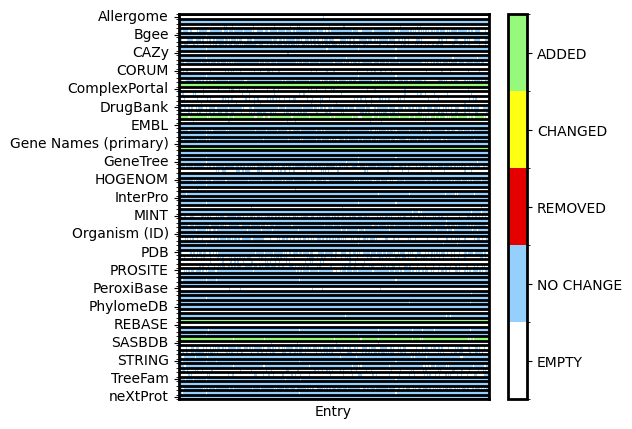

In [12]:
# Save query results to external database
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    try:
        df_previous = pd.read_csv(f"{database_dirpath}/{database_tag}_{version}.tsv", sep="\t", index_col=0, dtype=str)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=["Entry"])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index("Entry"),
        df_database.set_index("Entry")
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_database.to_csv(f"{database_dirpath}/{database_tag}_{version}.tsv", sep="\t")
else:
    df_database.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{database_tag}_{version}.tsv", sep="\t")
df_database

## Map results to model
### Genes

In [13]:
use_query_results = True
if use_query_results:
    df_model = pd.DataFrame.from_dict(
        {"From": model_search_mapping}, 
        orient="columns", 
    )
    df_model.index.name = annotation_type
    df_model = df_model.reset_index(drop=False)
    df_database = df_query_results.copy()
else:
    annotation_type = "genes"
    annotation_key = "ncbigene"
    df_model = get_annotation_df(model, annotation_type, [annotation_key])
    df_model.columns = [annotation_type, "From"]

    from_db = annotation_to_from_db[annotation_key]
    df_database = pd.read_csv(
        f"{database_dirpath}/{database_tag}_{version}.tsv", 
        sep="\t", 
        index_col=0,
        dtype=str,
    )

    df_database["From"] = df_database.loc[:, fromdb].str.strip(";")
    df_database = df_database.set_index("From")

df_annotations = df_model.merge(
    df_database, 
    left_on="From", 
    right_index=True,
    how="outer",
)
df_annotations = df_annotations.drop(["From"], axis=1).drop_duplicates().set_index("genes")
df_annotations

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology (GO),Chain,PubMed ID,...,HAMAP,InterPro,PANTHER,Pfam,PIRSF,PRINTS,ProDom,PROSITE,SMART,SUPFAM
genes,,,,,,,,,,,,,,,,,,,,,
ABCC4,O15439,ABCC4,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,7.6.2.-; 7.6.2.2; 7.6.2.3,RHEA:19121 RHEA:60128 RHEA:61364 RHEA:38963 RH...,UPI00001A36E6,apical plasma membrane [GO:0016324]; basolater...,"CHAIN 1..1325; /note=""ATP-binding cassette sub...",9661885; 12105214; 14702039; 15057823; 1548933...,...,NaN,IPR003593;IPR011527;IPR036640;IPR003439;IPR017...,PTHR24223;PTHR24223:SF357;,PF00664;PF00005;,NaN,NaN,NaN,PS50929;PS00211;PS50893;,SM00382;,SSF90123;SSF52540;
ABCG2,Q9UNQ0,ABCG2,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,7.6.2.2,RHEA:16461 RHEA:61332 RHEA:38951 RHEA:61348 RH...,UPI0000001275,apical plasma membrane [GO:0016324]; brush bor...,"CHAIN 1..655; /note=""Broad substrate specifici...",9850061; 9861027; 11306452; 11533706; 12958161...,...,NaN,IPR003593;IPR013525;IPR003439;IPR043926;IPR027...,PTHR48041;PTHR48041:SF92;,PF01061;PF19055;PF00005;,NaN,NaN,NaN,PS50893;,SM00382;,SSF52540;
ACP1,P24666,ACP1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.3.2; 3.1.3.48,RHEA:10684 RHEA:10684 RHEA:15017 RHEA:15017,UPI000013D926,cytoplasm [GO:0005737]; cytoplasmic side of pl...,"CHAIN 2..158; /note=""Low molecular weight phos...",1939112; 1627603; 1587862; 8586411; 1304913; 9...,...,NaN,IPR023485;IPR036196;IPR002115;IPR017867;,PTHR11717:SF7;PTHR11717;,PF01451;,NaN,PR00719;PR00720;,NaN,NaN,SM00226;,SSF52788;
ACSL1,P33121,ACSL1,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.15; 6.2.1.24; 6.2.1.3,RHEA:15421 RHEA:19713 RHEA:21380 RHEA:30751 RH...,UPI000004AC12,endoplasmic reticulum [GO:0005783]; endoplasmi...,"CHAIN 1..698; /note=""Long-chain-fatty-acid--Co...",1607358; 8584017; 14702039; 15815621; 15489334...,...,NaN,IPR025110;IPR020845;IPR000873;IPR042099;IPR045...,PTHR43272;PTHR43272:SF28;,PF00501;PF13193;,NaN,NaN,NaN,PS00455;,NaN,SSF56801;
ADA,P00813,ADA,9606,ALTERNATIVE PRODUCTS:,3.5.4.4,RHEA:24408 RHEA:28190,UPI000000D982,anchoring junction [GO:0070161]; cell surface ...,"CHAIN 2..363; /note=""Adenosine deaminase""; /id...",6090454; 6546794; 3839456; 3028473; 11780052; ...,...,MF_00540;,IPR006650;IPR028893;IPR001365;IPR006330;IPR032...,PTHR11409;PTHR11409:SF43;,PF00962;,NaN,NaN,NaN,PS00485;,NaN,SSF51556;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMPS,P11172,UMPS,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.4.2.10; 4.1.1.23,RHEA:10380 RHEA:11596,UPI0000001223,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,"CHAIN 2..480; /note=""Uridine 5'-monophosphate ...",3279416; 2624233; 9042911; 17974005; 16641997;...,...,MF_01208;,IPR013785;IPR014732;IPR018089;IPR001754;IPR023...,PTHR19278;PTHR19278:SF9;,PF00215;PF00156;,NaN,NaN,NaN,PS00156;PS00103;,SM00934;,SSF53271;SSF51366;
UROD,P06132,UROD,9606,ALTERNATIVE PRODUCTS:,4.1.1.37,RHEA:19865 RHEA:31239,UPI0000112E85,cytosol [GO:0005829]; nucleoplasm [GO:0005654]...,"CHAIN 1..367; /note=""Uroporphyrinogen decarbox...",3015909; 8644733; 14702039; 16710414; 15489334...,...,MF_00218;,IPR038071;IPR006361;IPR000257;,PTHR21091;PTHR21091:SF169;,PF01208;,NaN,NaN,NaN,PS00906;PS00907;,NaN,SSF51726;
UROS,P10746,UROS,9606,ALTERNATIVE PRODUCTS:,4.2.1.75,RHEA:18965,UPI000012C4A4,cytosol [GO:0005829]; mitochondrion [GO:000573...,"CHAIN 1..265; /note=""Uroporphyrinogen-III synt...",3174619; 11112350; 14702039; 15164054; 1548933...,...,NaN,IPR036108;IPR003754;IPR039793;,PTHR12390;PTHR12390:SF0;,PF02602;,NaN,NaN,NaN,NaN,NaN,SSF69618;


### Format UniProt information for annotation files
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [14]:
# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(get_query_fields_UniProt(miriam_only=True))
df_annotations = df_annotations.loc[:, list(uniprot_miriam_mapping)].rename(uniprot_miriam_mapping, axis=1)
df_annotations = df_annotations.loc[:, [
    "uniprot", 
    "uniprot.isoform",
    "uniprot.chain",
    "hgnc.symbol",
    "ncbigene",
    "ccds",
    "refseq",
    "mim",
    "drugbank",
    "dbsnp",
]]
df_annotations

,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank,dbsnp
genes,,,,,,,,,,
ABCC4,O15439,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..1325; /note=""ATP-binding cassette sub...",ABCC4,10257;,CCDS45061.1 [O15439-3];CCDS76643.1 [O15439-4];...,NP_001098985.1 [O15439-3];NP_001288758.1 [O154...,605250;,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...,rs11568681 rs11568689 rs4148460 rs45454092 rs1...
ABCG2,Q9UNQ0,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..655; /note=""Broad substrate specifici...",ABCG2,9429;,CCDS3628.1 [Q9UNQ0-1];CCDS58910.1 [Q9UNQ0-2];,NP_001244315.1 [Q9UNQ0-2];NP_004818.2 [Q9UNQ0-...,138900;603756;614490;,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...,rs2231137 rs1319203095 rs2231142 rs372192400 r...
ACP1,P24666,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 2..158; /note=""Low molecular weight phos...",ACP1,52;,CCDS1639.1 [P24666-1];CCDS1640.1 [P24666-2];CC...,NP_004291.1 [P24666-1];NP_009030.1 [P24666-2];,171500;,DB04214;DB00173;,rs11691572 rs79716074 rs35569198
ACSL1,P33121,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..698; /note=""Long-chain-fatty-acid--Co...",ACSL1,2180;,CCDS3839.1 [P33121-1];CCDS68826.1 [P33121-3];,NP_001273637.1 [P33121-1];NP_001273639.1 [P331...,152425;,DB00131;DB00171;,NaN
ADA,P00813,ALTERNATIVE PRODUCTS:,"CHAIN 2..363; /note=""Adenosine deaminase""; /id...",ADA,100;,CCDS13335.1;,NP_000013.2;,102700;608958;,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...,rs73598374 rs121908725 rs121908724 rs121908730...
...,...,...,...,...,...,...,...,...,...,...
UMPS,P11172,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 2..480; /note=""Uridine 5'-monophosphate ...",UMPS,7372;,CCDS3029.1 [P11172-1];,NP_000364.1 [P11172-1];,258900;613891;,DB02890;DB00544;,rs17843776 rs121917890 rs121917892 rs1801019 r...
UROD,P06132,ALTERNATIVE PRODUCTS:,"CHAIN 1..367; /note=""Uroporphyrinogen decarbox...",UROD,7389;,CCDS518.1;,NP_000365.3;,176100;613521;,DB03727;DB04461;,rs11541959 rs764268015 rs769378741 rs121918060...
UROS,P10746,ALTERNATIVE PRODUCTS:,"CHAIN 1..265; /note=""Uroporphyrinogen-III synt...",UROS,7390;,CCDS7648.1;,NP_000366.1;,263700;606938;,NaN,rs773301339 rs121908015 rs397515527 rs12190801...


In [15]:
df_isoforms_chains = df_annotations.loc[:, ["uniprot", "uniprot.isoform", "uniprot.chain"]].copy()
df_isoforms_chains = parse_isoforms_UniProt(df_isoforms_chains, add_canonical=True)
df_isoforms_chains = parse_chains_UniProt(df_isoforms_chains)
df_isoforms_chains

,uniprot,uniprot.isoform,uniprot.chain,uniprot.canonical
genes,,,,
ABCC4,O15439,O15439-1;O15439-2;O15439-3;O15439-4,PRO_0000093362,O15439-1
ABCG2,Q9UNQ0,Q9UNQ0-1;Q9UNQ0-2,PRO_0000093386,Q9UNQ0-1
ACP1,P24666,P24666-1;P24666-2;P24666-3;P24666-4,PRO_0000046558,P24666-1
ACSL1,P33121,P33121-1;P33121-2;P33121-3,PRO_0000193104,P33121-1
ADA,P00813,,PRO_0000194352,P00813
...,...,...,...,...
UMPS,P11172,P11172-1;P11172-2;P11172-3;P11172-4,PRO_0000139649,P11172-1
UROD,P06132,,PRO_0000187569,P06132
UROS,P10746,,PRO_0000135251,P10746


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank,dbsnp
0,ABCC4,O15439,NaN,PRO_0000093362,ABCC4,10257,CCDS45061.1;CCDS76643.1;CCDS86356.1;CCDS9474.1,NP_001098985.1;NP_001288758.1;NP_001288759.1;N...,605250,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...,rs11568681
1,ABCG2,Q9UNQ0,NaN,PRO_0000093386,ABCG2,9429,CCDS3628.1;CCDS58910.1,NP_001244315.1;NP_004818.2;XP_005263412.1;XP_0...,138900;603756;614490,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...,rs2231137
2,ACP1,P24666,NaN,PRO_0000046558,ACP1,52,CCDS1639.1;CCDS1640.1;CCDS46217.1,NP_004291.1;NP_009030.1,171500,DB04214;DB00173,rs11691572
3,ACSL1,P33121,NaN,PRO_0000193104,ACSL1,2180,CCDS3839.1;CCDS68826.1,NP_001273637.1;NP_001273639.1;NP_001273640.1;N...,152425,DB00131;DB00171,NaN
4,ADA,P00813,NaN,PRO_0000194352,ADA,100,CCDS13335.1,NP_000013.2,102700;608958,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...,rs73598374
...,...,...,...,...,...,...,...,...,...,...,...
278,UMPS,P11172,NaN,PRO_0000139649,UMPS,7372,CCDS3029.1,NP_000364.1,258900;613891,DB02890;DB00544,rs17843776
279,UROD,P06132,NaN,PRO_0000187569,UROD,7389,CCDS518.1,NP_000365.3,176100;613521,DB03727;DB04461,rs11541959
280,UROS,P10746,NaN,PRO_0000135251,UROS,7390,CCDS7648.1,NP_000366.1,263700;606938,NaN,rs773301339
281,XYLB,O75191,NaN,PRO_0000230985,XYLB,9942,CCDS2678.1,NP_005099.2,604049,NaN,rs17118


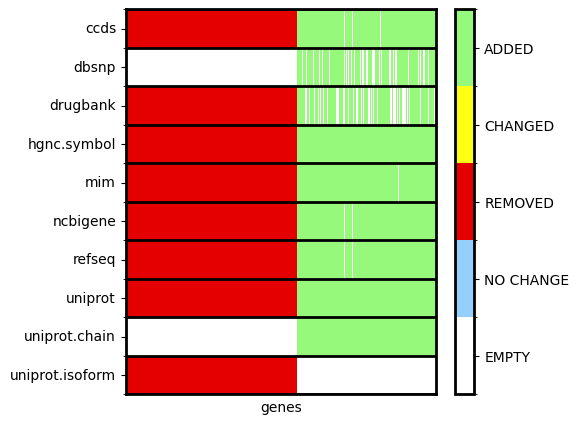

In [16]:
# Identify isoforms and chains
df_isoforms_chains = df_annotations.loc[:, ["uniprot", "uniprot.isoform", "uniprot.chain"]].copy()
df_isoforms_chains = parse_isoforms_UniProt(df_isoforms_chains, add_canonical=True)
df_isoforms_chains = parse_chains_UniProt(df_isoforms_chains)


double_check = []
for gene, (uniprot_id, isoforms) in df_isoforms_chains.loc[:, ["uniprot", "uniprot.isoform"]].iterrows():
    isoforms = isoforms.split(";")
    isonum = gene.split("_AT")[-1]
    expected_isoform = f"{uniprot_id}-{isonum}"
    if expected_isoform in isoforms:
        df_isoforms_chains.loc[gene, "uniprot.isoform"] = expected_isoform
    else:
        double_check += [gene]
        df_isoforms_chains.loc[gene, "uniprot.isoform"] = float("nan")

df_annotations["uniprot.isoform"] = df_isoforms_chains["uniprot.isoform"]
df_annotations["uniprot.chain"] = df_isoforms_chains["uniprot.chain"]
columns = ["ncbigene", "ccds", "refseq", "mim", "drugbank", "dbsnp"]
for idx, row in df_annotations.loc[:, columns].iterrows():
    uniprot_id, isoform_id = df_isoforms_chains.loc[idx, ["uniprot", "uniprot.isoform"]].fillna("")
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(lambda x: get_isoform_value_from_entry_UniProt(x, isoform_id))
    df_annotations.loc[idx, columns] = row.values
df_annotations = df_annotations.reset_index(drop=False)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", 
            sep="\t", 
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if overwrite:
    df_annotations.to_csv(f"{annotation_dirpath}/{annotation_type}_{database_tag}.tsv", sep="\t")
else:
    df_annotations.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{database_tag}.tsv", sep="\t")
df_annotations

#### Double check

In [17]:
df_annotations.set_index(annotation_type).loc[double_check]

,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ncbigene,ccds,refseq,mim,drugbank,dbsnp
genes,,,,,,,,,,
ABCC4,O15439,NaN,PRO_0000093362,ABCC4,10257,CCDS45061.1;CCDS76643.1;CCDS86356.1;CCDS9474.1,NP_001098985.1;NP_001288758.1;NP_001288759.1;N...,605250,DB00718;DB00770;DB01076;DB00171;DB01327;DB0048...,rs11568681
ABCG2,Q9UNQ0,NaN,PRO_0000093386,ABCG2,9429,CCDS3628.1;CCDS58910.1,NP_001244315.1;NP_004818.2;XP_005263412.1;XP_0...,138900;603756;614490,DB12001;DB08916;DB11363;DB00437;DB12015;DB0349...,rs2231137
ACP1,P24666,NaN,PRO_0000046558,ACP1,52,CCDS1639.1;CCDS1640.1;CCDS46217.1,NP_004291.1;NP_009030.1,171500,DB04214;DB00173,rs11691572
ACSL1,P33121,NaN,PRO_0000193104,ACSL1,2180,CCDS3839.1;CCDS68826.1,NP_001273637.1;NP_001273639.1;NP_001273640.1;N...,152425,DB00131;DB00171,NaN
ADA,P00813,NaN,PRO_0000194352,ADA,100,CCDS13335.1,NP_000013.2,102700;608958,DB07711;DB07783;DB07786;DB04218;DB07785;DB0301...,rs73598374
...,...,...,...,...,...,...,...,...,...,...
UMPS,P11172,NaN,PRO_0000139649,UMPS,7372,CCDS3029.1,NP_000364.1,258900;613891,DB02890;DB00544,rs17843776
UROD,P06132,NaN,PRO_0000187569,UROD,7389,CCDS518.1,NP_000365.3,176100;613521,DB03727;DB04461,rs11541959
UROS,P10746,NaN,PRO_0000135251,UROS,7390,CCDS7648.1,NP_000366.1,263700;606938,NaN,rs773301339
